Changelog:  (Last Updated 2025-02-26)

# Probabilistic ML: Assignment 3
- **Deadline**: 2025-03-16 (March 16th 2025, 23:59)
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.

- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

# 1. [54pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [1]:
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
    # axis=-1 means sum over the last dimension.
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

## Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log\_joint\_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [32]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

**b)** The function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [2]:
def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_20_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 20.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_20_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_20_times(z1, z2))

def log_posterior_beat_each_other_20_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 20.* logp_a_beats_b(z1, z2) \
        + 20.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_20_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_20_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [3]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')

    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## **1.1 [20pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [9pts]** Implement the missing lines in the below code, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [ ]:
def diag_gaussian_samples(mean, log_std, num_samples):
    # mean and log_std are (D) dimensional vectors
    # Return a (num_samples, D) matrix, where each sample is
    # from a diagonal multivariate Gaussian.

    # TODO.  You might want to use torch.randn(). Remember
    # you must use the reparameterization trick.  Also remember that
    # we are parameterizing the _log_ of the standard deviation.

    epsilon = torch.randn(num_samples, mean.shape[0])
    return mean + torch.exp(log_std) * epsilon


def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate the density of a batch of points on a
    # diagonal multivariate Gaussian. x is a (num_samples, D) matrix.
    # Return a tensor of shape (num_samples)

    return diag_gaussian_log_density(x, mean, torch.exp(log_std))


def batch_elbo(logprob, mean, log_std, num_samples):
    # TODO: Use simple Monte Carlo to estimate ELBO
    # on a batch of size num_samples

    samples = diag_gaussian_samples(mean, log_std, num_samples)
    log_q = diag_gaussian_logpdf(samples, mean, log_std)
    return torch.sum(logprob - log_q) / num_samples


**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters, and returns an unbiased estimate of the negative elbo using $\texttt{num\_samples\_per\_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 20 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [5]:
# Hyperparameters
num_players = 2
n_iters = 1200
stepsize = 0.0001
num_samples_per_iter = 80

def log_posterior_A_beat_B_20_times_1_arg(z1z2):
  return log_posterior_A_beat_B_20_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):  # The loss function to be minimized.
  # TODO.  Hint:  This can be done in one line.

  samples = diag_gaussian_samples(params[0], params[1], num_samples_per_iter)
  log_prob = log_posterior_A_beat_B_20_times_1_arg(samples)

  return -batch_elbo(log_prob, params[0], params[1], num_samples_per_iter)

**c) [1pts]** Initialize a set of variational parameters and optimize them to approximate the joint where we observe player A winning 20 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Any initialization should be fine.  How many variational parameters do you need?

Optimizing variational parameters...


  4%|▍         | 47/1200 [00:00<00:10, 108.50it/s]

Iteration 0 lower bound 264.70306396484375
Iteration 25 lower bound 31.78597068786621
Iteration 50 lower bound 15.099512100219727
Iteration 75 lower bound 13.45228099822998


 15%|█▍        | 179/1200 [00:00<00:03, 305.06it/s]

Iteration 100 lower bound 10.58454704284668
Iteration 125 lower bound 7.891526699066162
Iteration 150 lower bound 6.811938285827637
Iteration 175 lower bound 6.119801998138428


 22%|██▏       | 269/1200 [00:01<00:02, 372.84it/s]

Iteration 200 lower bound 5.410181522369385
Iteration 225 lower bound 4.807015895843506
Iteration 250 lower bound 5.546432018280029
Iteration 275 lower bound 5.134564399719238


 30%|██▉       | 355/1200 [00:01<00:02, 397.71it/s]

Iteration 300 lower bound 4.447048187255859
Iteration 325 lower bound 4.469286918640137
Iteration 350 lower bound 4.996598243713379
Iteration 375 lower bound 4.3986310958862305


 37%|███▋      | 443/1200 [00:01<00:01, 415.21it/s]

Iteration 400 lower bound 4.459961891174316
Iteration 425 lower bound 4.209531307220459
Iteration 450 lower bound 4.268887519836426
Iteration 475 lower bound 3.72737193107605


 48%|████▊     | 576/1200 [00:01<00:01, 430.71it/s]

Iteration 500 lower bound 4.208773612976074
Iteration 525 lower bound 4.694693565368652
Iteration 550 lower bound 4.262420654296875
Iteration 575 lower bound 4.453737258911133
Iteration 600 lower bound 4.415223121643066


 55%|█████▌    | 664/1200 [00:01<00:01, 426.19it/s]

Iteration 625 lower bound 4.784109592437744
Iteration 650 lower bound 4.27078914642334
Iteration 675 lower bound 4.662172317504883
Iteration 700 lower bound 4.332550525665283


 66%|██████▋   | 796/1200 [00:02<00:00, 434.05it/s]

Iteration 725 lower bound 4.004646301269531
Iteration 750 lower bound 4.353650093078613
Iteration 775 lower bound 4.2084174156188965
Iteration 800 lower bound 3.9847354888916016


 74%|███████▍  | 886/1200 [00:02<00:00, 437.84it/s]

Iteration 825 lower bound 3.9169845581054688
Iteration 850 lower bound 3.982245683670044
Iteration 875 lower bound 4.337024688720703
Iteration 900 lower bound 3.848128080368042


 81%|████████  | 974/1200 [00:02<00:00, 385.89it/s]

Iteration 925 lower bound 4.015576362609863
Iteration 950 lower bound 3.837563991546631
Iteration 975 lower bound 3.905480146408081


 88%|████████▊ | 1062/1200 [00:02<00:00, 409.81it/s]

Iteration 1000 lower bound 4.411314487457275
Iteration 1025 lower bound 3.8338534832000732
Iteration 1050 lower bound 4.407772064208984
Iteration 1075 lower bound 4.0817694664001465


 96%|█████████▌| 1149/1200 [00:03<00:00, 418.99it/s]

Iteration 1100 lower bound 4.410593509674072
Iteration 1125 lower bound 4.0895185470581055
Iteration 1150 lower bound 3.8675665855407715
Iteration 1175 lower bound 3.8716628551483154


100%|██████████| 1200/1200 [00:03<00:00, 366.67it/s]
c:\Users\P8Z77WS\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


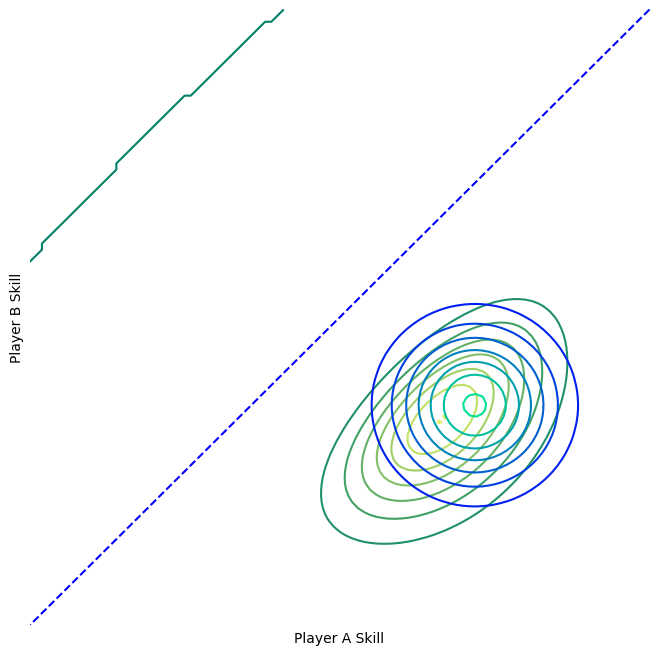

<Figure size 640x480 with 0 Axes>

In [6]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params)))

# Set up optimizer.
D = 2
init_log_std = torch.tensor([2, 3], dtype=torch.float32, requires_grad=True)
init_mean = torch.tensor([1, 1], dtype=torch.float32, requires_grad=True)


params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)


def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params[0].detach(), params[1].detach()
    return torch.exp(diag_gaussian_logpdf(torch.stack([z1, z2], dim=2), mean, logstd))

plot_2d_fun(posterior_A_beat_B_20_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

**d) [3pt]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters , and returns a negative elbo estimate using simple Monte carlo with $\texttt{num\_samples\_per\_iter}$ samples, to approximate the joint where we observe player A winning 20 games and player B winning 20 games.

Hint:  You can find analogous functions in the code above.


In [7]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_beat_each_other_20_times_1_arg(z1z2):
    # z1z2 is a tensor with shape (num_samples x 2)
    # Return a tensor with shape (num_samples)

    return log_posterior_beat_each_other_20_times(z1z2[:,0], z1z2[:,1]).flatten()


def objective(params):
  samples = diag_gaussian_samples(params[0], params[1], num_samples_per_iter)
  log_prob = log_posterior_beat_each_other_20_times_1_arg(samples)

  return -batch_elbo(log_prob, params[0], params[1], num_samples_per_iter)


**e) [3pt]** Run the code below to optimize, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Optimizing variational parameters...


 36%|███▌      | 36/100 [00:00<00:00, 349.76it/s]

Iteration 0 lower bound 30.73189926147461
Iteration 25 lower bound 31.714609146118164
Iteration 50 lower bound 30.956510543823242


100%|██████████| 100/100 [00:00<00:00, 372.01it/s]


Iteration 75 lower bound 30.098180770874023


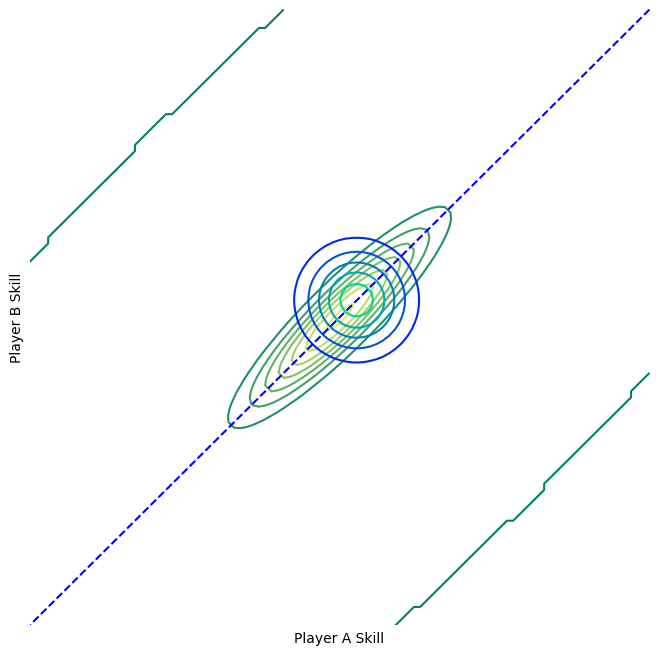

<Figure size 640x480 with 0 Axes>

In [10]:
# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

plot_2d_fun(posterior_beat_each_other_20_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

## 1.2 [34 pts] Approximate inference conditioned on real data

The dataset contains data on 2500 games amongst 33 Premier League teams:
 - names is a 33 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2500 by 2 matrix of game outcomes, one row per game.

The first column contains the indices of the team who won.
The second column contains the indices of the team who lost.

It is based on the following kaggle dataset: https://www.kaggle.com/datasets/evangower/premier-league-matches-19922022

<!-- The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess -->




In [11]:
# Download the dataset
!curl -L -o premier-league-matches-19922022.zip\
  https://www.kaggle.com/api/v1/datasets/download/evangower/premier-league-matches-19922022
!unzip premier-league-matches-19922022.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  2 81859    2  1923    0     0    961      0  0:01:25  0:00:02  0:01:23  1295
 41 81859   41 34101    0     0  17050      0  0:00:04  0:00:02  0:00:02 18187
100 81859  100 81859    0     0  40929      0  0:00:02  0:00:02 --:--:-- 36906
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
from sklearn.preprocessing import LabelEncoder

def load_games():
    dataset = pd.read_csv("premier-league-matches.csv")
    mini_ds = dataset[dataset['FTR'] != 'D'][-2500:]
    all_teams = pd.concat((mini_ds['Home'], mini_ds['Away'])).unique()
    encoder = LabelEncoder()
    encoder.fit(all_teams)
    mini_ds['HomeId'] = encoder.transform(mini_ds['Home'])
    mini_ds['AwayId'] = encoder.transform(mini_ds['Away'])

    winner_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['HomeId'], mini_ds['AwayId'])
    loser_ids = np.where(mini_ds['FTR'] == 'H', mini_ds['AwayId'], mini_ds['HomeId'])
    games = np.column_stack((winner_ids, loser_ids))
    names = encoder.classes_

    return games, names

games, names = load_games()
games = torch.LongTensor(games)



**a) [0pt]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log\_games\_likelihood}$ takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills.


In [15]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs]
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

In [29]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [4pt]** Write a new objective function like the one from the previous question.

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset.

In [30]:
# Hyperparameters
num_players = 33
n_iters = 200
stepsize = 0.0001
num_samples_per_iter = 50

def objective(params):
    samples = diag_gaussian_samples(params[0], params[1], num_samples_per_iter)
    log_prob = log_joint_probability(samples)

    return -batch_elbo(log_prob, params[0], params[1], num_samples_per_iter)

**c) [3pts]** Optimize, and report the final loss.

In [33]:
# Set up optimizer.
init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Optimize and print loss in a loop
# HINT: you can use the callback() function to report loss

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)


Optimizing variational parameters...


  0%|          | 1/200 [00:00<00:25,  7.86it/s]

Iteration 0 lower bound 2268.58740234375


  8%|▊         | 16/200 [00:00<00:02, 81.34it/s]

Iteration 25 lower bound 1707.095947265625

 20%|██        | 41/200 [00:00<00:01, 107.02it/s]


Iteration 50 lower bound 1586.0826416015625


 49%|████▉     | 98/200 [00:00<00:00, 134.31it/s]

Iteration 75 lower bound 1551.2808837890625
Iteration 100 lower bound 1537.6328125


 70%|███████   | 141/200 [00:01<00:00, 132.27it/s]

Iteration 125 lower bound 1528.7457275390625
Iteration 150 lower bound 1525.1016845703125


 98%|█████████▊| 197/200 [00:01<00:00, 126.42it/s]

Iteration 175 lower bound 1519.501220703125


100%|██████████| 200/200 [00:01<00:00, 121.27it/s]


**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

In [34]:
# mean_skills, logstd_skills = # TODO.  Hint: You don't need to do simple Monte Carlo here.
# Hint: You should use .detach() before you do anything with the params tensors

mean_skills = params[0].detach()
logstd_skills = params[1].detach()

sorted_indices = torch.argsort(-mean_skills)

for i in sorted_indices:
    print("mean:", mean_skills[i].item(), "log std:", logstd_skills[i].item())

mean: 1.8326363563537598 log std: -1.379943609237671
mean: 1.6582595109939575 log std: -1.3477920293807983
mean: 1.1505179405212402 log std: -1.4292621612548828
mean: 1.05368971824646 log std: -1.4773828983306885
mean: 1.0453026294708252 log std: -1.4781662225723267
mean: 0.9985929727554321 log std: -1.449684739112854
mean: 0.3889390528202057 log std: -1.4964972734451294
mean: 0.3088916838169098 log std: -0.7784097790718079
mean: 0.24081002175807953 log std: -1.220115303993225
mean: 0.1332583874464035 log std: -1.4899338483810425
mean: 0.05863722786307335 log std: -1.48753023147583
mean: 0.057465698570013046 log std: -1.2601937055587769
mean: 0.013844476081430912 log std: -1.4237120151519775
mean: -0.0484359972178936 log std: -1.4832000732421875
mean: -0.10622209310531616 log std: -1.0401774644851685
mean: -0.1658722162246704 log std: -1.476392149925232
mean: -0.18369224667549133 log std: -1.3377306461334229
mean: -0.18715862929821014 log std: -0.9842365384101868
mean: -0.2109284847974

**e) [1pts]** List the names of the 10 players with the highest mean skill under the variational model.

In [35]:
for i in range(10):
    print(names[sorted_indices[i]])

Manchester City
Liverpool
Manchester Utd
Tottenham
Arsenal
Chelsea
Leicester City
Brentford
Wolves
West Ham


**f) [3pt]** Plot samples from the joint posterior over the skills of Arsenal and Liverpool. Based on your samples, describe in a sentence the relationship between the skills of the teams. (Is one better than the other? Are they approximately even?)

Arsenal
Liverpool


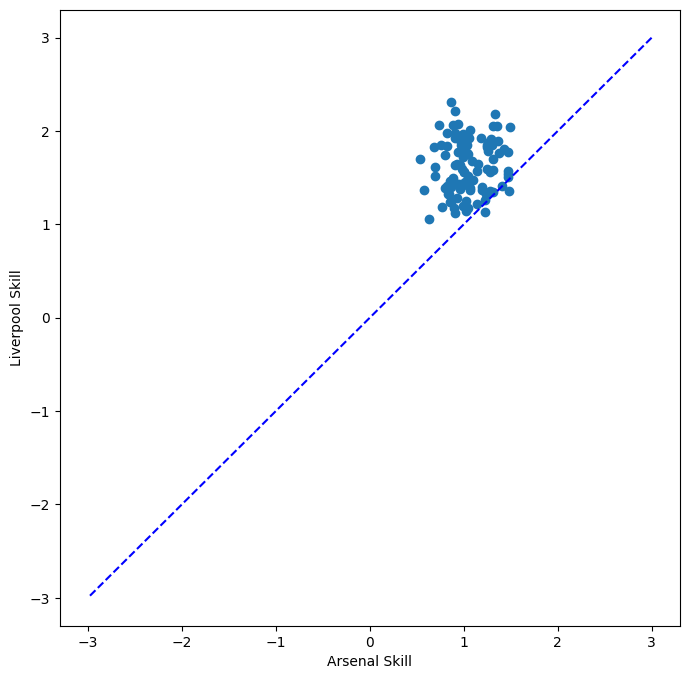

In [39]:
arsenal_ix = 0
liverpool_ix = 15
print(names[arsenal_ix])
print(names[liverpool_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("Arsenal Skill")
plt.ylabel("Liverpool Skill")

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)


# TODO:  Hint:  Use plt.scatter()
arsenal_samples = samples[:, arsenal_ix]
liverpool_samples = samples[:, liverpool_ix]

plt.scatter(arsenal_samples, liverpool_samples)




**g) [8pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim \mathcal N (\mu, \Sigma)$, then $AX \sim \mathcal N (A\mu, A\Sigma A^T)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim \mathcal N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim \mathcal N (\mu_i , \Sigma_{ii})$.

Your answer here.

**h) [4pts]** Compute the probability under your approximate posterior that Arsenal has higher skill than Liverpool. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `Normal(0,1).cdf()` for the exact formula.

In [ ]:
# TODO

**i) [2pts]** Compute the probability that Arsenal is better than the player with the 5th lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [ ]:
# TODO


**j) [4 pts]** Imagine that we knew ahead of time that we were examining the skills of top chess players, and so changed our prior on all players to Normal(5, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?

Your answer here.

**k) [4 pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

Your answer here.

# 2. [21pts] Question 2: VAE with synthetic data

In this question, we will train a VAE on a synthetic data which resembles spirals in 2d. We will perform amortized inference with VAEs.

Function below generates the synthetic knot shape data.

In [ ]:
def make_banana_data(num_classes, num_per_class, noise_std=0.3):
    # Create points in the shape of a banana
    features = []
    labels = []

    for i in range(num_classes):
        theta = torch.linspace(0, np.pi, num_per_class) + i * (2 * np.pi / num_classes)  # spread across the circle
        x = torch.sin(theta) + noise_std * torch.randn_like(theta)  # add some noise
        y = torch.cos(theta) * (torch.sin(theta) + noise_std * torch.randn_like(theta))  # banana shape, noise too

        features.append(torch.stack([x, y], dim=1))
        labels.extend([i] * num_per_class)

    # Concatenate features and labels
    features = torch.cat(features, dim=0)
    labels = torch.tensor(labels).long()

    # Shuffle the dataset
    perm_ix = torch.randperm(labels.shape[0])
    return labels[perm_ix], features[perm_ix]

We visualize the 2d data generated from the above function. Notice that there are 3 clusters in the input space, each colored with a different color. The VAE will not see the cluster assignments, but we hope to recover this structure in the latent space.

In [ ]:
num_clusters = 3
samples_per_cluster = 300
labels, data = make_banana_data(num_clusters, samples_per_cluster, 0.02)


for k in range(num_clusters):
    plt.scatter(data[labels == k, 0], data[labels == k, 1], s=2)

plt.axis("equal")

## 2.1 [12 pts] Implement the missing lines in the below code, to complete the $\texttt{elbo}$ function for a variational autoencoder.

The banana dataset and an example encoder / decoder is provided just to help you debug.


In [ ]:
# Generic VAE functions.

def log_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

def diag_gaussian_samples(mean, log_std, num_samples):
    return mean + torch.exp(log_std) * torch.randn(num_samples, mean.shape[-1])

def diag_gaussian_logpdf(x, mean, log_std):
    return diag_gaussian_log_density(x, mean, torch.exp(log_std))


def batch_elbo(  # Simple Monte Carlo estimate of the variational lower bound.
    recognition_net,    # takes a batch of datapoints, outputs mean and log_std of size (batch_size x latent_dim), i.e. log q(z|x)
    decoder_net,        # takes a batch of latent samples, outputs mean and log_std of size (batch_size x data_dim), i.e. log p(x|z)
    log_joint,          # takes decoder_net, a batch of latent samples, and a batch of datapoints, outputs unnormalized log joint, i.e. log p(x,z)
    data                # a.k.a. x
    ):
    #TODO

The below code trains a VAE where the encoder and decoder are both neural networks. The parameters are specified in the starter code.  You don't need to do anything here, this is just to help you debug.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# Now define a specific VAE for the spiral dataset

data_dimension = 2
latent_dimension = 2

# Define the recognition network.
class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension) # Output mean of q(z)
        self.std_net = nn.Linear(50, latent_dimension) # Output log_std of q(z)

    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

recognition_net = RecognitionNet(data_dimension, latent_dimension)

# Define the decoder network.
# Note that it has two outputs, a mean and a variance, because
# this model has a Gaussian likelihood p(x|z).
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, data_dimension) # Output mean of p(x|z)
        self.std_net = nn.Linear(50, data_dimension) # Output log_std of p(x|z)

    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

decoder_net = Decoder(latent_dimension, data_dimension)

# Set up log likelihood function.
def log_likelihood(decoder_net, latent, data):
    mean, log_std = decoder_net(latent)
    return diag_gaussian_logpdf(data, mean,
                                np.log(0.1) + 0. * log_std)  # Note: we are cheating here and using a fixed noise variance to make optimization more stable.

def log_joint(decoder_net, latent, data):
    return log_prior(latent) + log_likelihood(decoder_net, latent, data)

# Run optimization
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()},
                      {'params': decoder_net.parameters()}], lr=1e-3)
n_iters = 2000
minibatch_size = 300

dataset = TensorDataset(torch.tensor(data))
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):  # The loss function to be minimized.
    minibatch = next(iter(dataloader))[0]
    return -batch_elbo(
    recognition_net,
    decoder_net,
    log_joint,
    minibatch)

def callback(t):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

## 2.2 [5 pts]  In this part, we visualize how the data looks like in the latent space. We simply use the trained recognition network (the encoder) to map each input to latent space.


In [ ]:
# Show the means of the encoded data in a 2D latent space.
# Don't worry if this doesn't look much like a Gaussian.

for k in range(num_clusters):
    # cur_data =  # TODO get all the data from this cluster.
    # transformed =  # TODO find the mean of q(z|x) for each x.

plt.axis("equal")
plt.xlabel("latent dimension 1")
plt.ylabel("latent dimension 2")

## 2.3 [4pts] Generate new data using the decoder and the generative model we just trained.

For this, we simply generate 1500 latent variables in the latent space from the prior and pass it through the decoder network.

You shouldn't expect this to match the data exactly, just to get the overall shape and number of clusters roughly correct.  


In [ ]:
# Sample data from the trained generative model to see if it
# roughly matches the data.  # Note: This doesn't add the likelihood noise,
# although it should if we want it to match the data.

num_samples = 1500
# samples =  # TODO
# transformed =  # TODO



Here's a debugging tool only available when both the latent space and the data are both 2-dimensional.  We can show the function being learned by the encoder by showing how it warps a 2D grid into the latent space.

In [ ]:
from matplotlib.collections import LineCollection

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return decoder_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()

Here, we show the function being learned by the decoder by showing how it warps a 2D grid into the observed space.



In [ ]:
def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return recognition_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()